================================Enabling GPU==============================

In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

In [2]:
 from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())
device = ""

for i in device_lib.list_local_devices():
  if i.name == '/device:GPU:0':
    device = '/device:GPU:0'
    break
  elif i.name == '/device:XLA_GPU:0':
    device = '/device:XLA_GPU:0'

print(device)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14801414888125609697
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 9938862080
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12925766323740145534
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 4070, pci bus id: 0000:01:00.0, compute capability: 8.9"
xla_global_id: 416903419
]
/device:GPU:0


I0000 00:00:1742004719.431569   14851 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1742004719.431687   14851 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1742004719.431768   14851 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1742004719.478040   14851 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [3]:
import tensorflow as tf
import segmentation_models as sm
import glob
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras import layers, models
# import tensorflow.keras as keras

# from keras.utils import normalize
# from keras.metrics import MeanIoU
from PIL import Image

Segmentation Models: using `keras` framework.


================================Loading dataset================================

In [4]:
#Resizing images, if needed
SIZE_X = 128
SIZE_Y = 128
n_classes=3 #Number of classes for segmentation

#Capture training image info as a list

In [5]:
train_images = []
# Path to the directory containing images
directory_path = "/home/chun/Downloads/final_tensor/final_tensor/Images"

# Get all .png files in the directory
img_paths = glob.glob(os.path.join(directory_path, "*.png"))

# Sort the file paths based on the numerical part of the filenames
# Assuming filenames are like <some_string>_<number>.png
img_paths.sort(key=lambda x: int(os.path.basename(x).split('.')[0].split('-')[1]))

# Read and process each image
for img_path in img_paths:
    img = cv2.imread(img_path, 1)  # Read image in color mode
    img = cv2.resize(img, (SIZE_Y, SIZE_X))  # Resize image
    train_images.append(img)  # Append processed image to the list

In [6]:
train_images = np.array(train_images)
train_images.shape

(130, 128, 128, 3)

In [7]:
train_masks = []
# Path to the directory containing images
directory_path = "/home/chun/Downloads/final_tensor/final_tensor/Mask3"

# Get all .png files in the directory
mask_path = glob.glob(os.path.join(directory_path, "*.png"))

# Sort the file paths based on the numerical part of the filenames
# Assuming filenames are like Cell-1_G.png
mask_path.sort(key=lambda x: int(os.path.basename(x).split('_')[0].split('-')[1]))

# Read and process each image
for mask_path in mask_path:
    mask = cv2.imread(mask_path, 0)  # Read image in grayscale
    mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)  # Resize image
    train_masks.append(mask)  # Append processed image to the list


In [8]:
train_masks = np.array(train_masks)
train_masks.shape

(130, 128, 128)

================================Encoding labels ================================

In [9]:
#Encode labels... but multi dim array so need to flatten, encode and reshape
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = train_masks.shape
train_masks_reshaped = train_masks.reshape(-1,1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

np.unique(train_masks_encoded_original_shape)

/home/chun/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0, 1, 2])

In [10]:
train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)

#Create a subset of data for quick testing
#Picking 10% for testing and remaining for training
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_images, train_masks_input, test_size = 0.10, random_state = 0)

In [11]:
#Only train 50% for resource constriant
# X_train, X_do_not_use, y_train, y_do_not_use = train_test_split(X1, y1, test_size = 0.5, random_state = 0)

In [12]:
train_masks_input.shape

(130, 128, 128, 1)

In [13]:
#One hot encoded, so each pixel has a vector of 4 where the label index is 1

train_masks_cat = tf.keras.utils.to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))

In [14]:
test_masks_cat = tf.keras.utils.to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

######################################################

In [15]:
y_train_cat.shape

(117, 128, 128, 3)

In [16]:
activation = 'softmax'

========================Creating Generator====================

In [17]:
def make_generator_model(load=True):
  BACKBONE1 = 'resnet34'
  if load:
    return tf.keras.models.load_model("res34_backbone_50epoch_mydata-1736814312.8437614.keras", compile=False)
  else:
    return sm.Unet(BACKBONE1, encoder_weights='imagenet', classes=n_classes, activation=activation)

In [18]:
BACKBONE1 = 'resnet34'
preprocess_input1 = sm.get_preprocessing(BACKBONE1)
X_train1 = preprocess_input1(X_train)
X_test1 = preprocess_input1(X_test)

In [19]:
np.array(X_train1[0:1]).shape

(1, 128, 128, 3)

I0000 00:00:1742004724.305776   14851 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1742004724.305979   14851 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1742004724.306082   14851 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1742004724.306203   14851 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

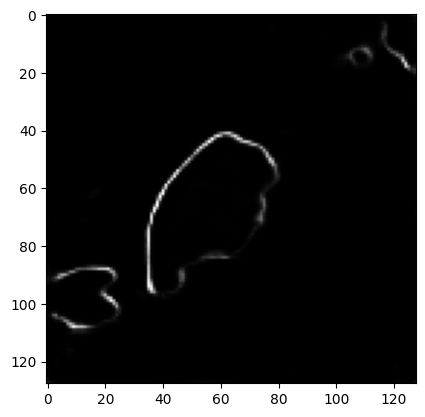

In [20]:
generator = make_generator_model()
generated_image = generator(X_train1[0:1], training = False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [21]:
generated_image.numpy().shape

(1, 128, 128, 3)

In [22]:
test_disc = np.concatenate([generated_image.numpy(), X_train1[0:1]], axis = -1)

=============Creating discriminator===================

In [23]:
def make_discriminator_model(input_shape, load=True):
  if load:
    return tf.keras.models.load_model("disc-1-31-16-25.keras", compile=False)
  image_input = layers.Input(shape=input_shape)  # Original image (RGB)
  mask_input = layers.Input(shape=input_shape)
  input = layers.Concatenate(axis=-1)([image_input, mask_input])
  x = layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same')(input)
  x = layers.LeakyReLU(0.2)(x)
  x = layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same')(x)
  x = layers.LeakyReLU(0.2)(x)
  x = layers.Flatten()(x)
  x = layers.Dense(1, activation='sigmoid')(x)
  return models.Model(input, x)

In [24]:
input_shape = (SIZE_X, SIZE_Y, n_classes)
discriminator = make_discriminator_model(input_shape)
decision = discriminator(test_disc)
print(decision)

tf.Tensor([[6.1738133e-06]], shape=(1, 1), dtype=float32)


W0000 00:00:1742004727.983589   14851 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1742004727.984030   14851 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1742004727.984313   14851 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1742004727.984610   14851 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1742004727.985989   14851 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1742004727.986278   14851 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1742004727.986704   14851 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1742004727.986995   14851 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1742004727.987284   14851 gp

==================Define Loss function==================

In [25]:
from tensorflow.keras import backend as K
def debug_binary_crossentropy_loss(y_true, y_pred):
    """
    Custom binary crossentropy loss function with debug prints.
    Args:
        y_true: Ground truth labels (1 for real, 0 for fake).
        y_pred: Predicted probabilities (output of discriminator).
    Returns:
        The computed binary crossentropy loss.
    """
    # Clip predictions to avoid log(0) or log(1)
    y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())

    # Compute binary crossentropy loss
    loss = K.mean(K.binary_crossentropy(y_true, y_pred), axis=-1)

    # Debug prints
    # print("y_true shape:", y_true.shape)
    # print("y_pred shape:", y_pred.shape)
    # print("Sample y_true values:", K.eval(y_true[:5]))  # Print first 5 values
    # print("Sample y_pred values:", K.eval(y_pred[:5]))  # Print first 5 values
    # print("Computed binary crossentropy loss:", K.eval(loss))

    return loss

In [52]:
def discriminator_loss(real_output, fake_output):
    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    # print(f"Total_loss : {total_loss}")
    return total_loss

# def generator_loss(y_true, y_pred):
#     dice_loss = sm.losses.DiceLoss(class_weights=np.array([0.33, 0.33, 0.34])) ## IOU: Area of Overlap / Area of Union
#     focal_loss = sm.losses.CategoricalFocalLoss()
#     # print("y_true shape:", y_true.shape, "y_pred shape:", y_pred.shape)
#     # print(f"debug_loss : {dice_loss(y_true, y_pred) + (1 * focal_loss(y_true, y_pred))}")
#     total_loss = dice_loss(y_true, y_pred) + (1 * focal_loss(y_true, y_pred))
#     # print(f"dice_loss : {dice_loss(y_true, y_pred)}, focal_loss : {focal_loss(y_true, y_pred)}, total_loss : {total_loss}")
#     return total_loss
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = tf.compat.v1.losses.sigmoid_cross_entropy(multi_class_labels = tf.ones_like(disc_generated_output), logits = disc_generated_output)
  # mean absolute error
    l1_loss = tf.cast(tf.reduce_mean(tf.abs(target - gen_output)), tf.float64)
    gan_loss = tf.cast(gan_loss, tf.float64)
    LAMBDA = 100
    total_gen_loss = gan_loss + (LAMBDA * l1_loss)
    return total_gen_loss

# total_loss = debug_loss


In [27]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [28]:
from datetime import datetime

# Get the current date and time
now = datetime.now()

# Extract the month, day, hour, and minute
current_month = now.month
current_day = now.day
current_hour = now.hour
current_minute = now.minute
type(current_minute)

int

In [29]:
from datetime import datetime

# Get the current date and time
now = datetime.now()

cur_date = f"{now.month}-{now.day}-{now.hour}-{now.minute}"
checkpoint_dir = './new_gan_example'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt" + cur_date)
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [30]:
# @title

# #Testing gen loss function

# fake_masks = np.argmax(generated_image, axis=3)[:,:,:].astype('float64')
# fake_masks = np.expand_dims(fake_masks, axis=-1)
# print(fake_masks.dtype)
# print(y_train[0:1].astype('float32').dtype)
# print(fake_masks.shape)
# print(y_train[0:1].shape)
# dice = sm.losses.DiceLoss(class_weights=np.array([0.33, 0.33, 0.34]))
# dice(fake_masks, y_train[0:1].astype('float64'))
# generator_loss(fake_masks, y_train[0:1].astype('float64'))

In [31]:
# @title
# #Testing disc loss function
# fake_output = fake_masks
# real_output = y_train[0:1]
# disc_loss = discriminator_loss(real_output, fake_output)
# disc_loss

In [32]:
# @title
# batch_size = 8
# idx = np.random.randint(0, len(X_train), batch_size)
# real_images = X_train[idx]
# real_masks = y_train[idx]
# type(real_images)

In [33]:
# @title
# test = generator(real_images, training=True)
# test = tf.math.argmax(test, axis=3)[:,:,:]
# test = tf.keras.utils.to_categorical(test, num_classes=n_classes)
# print(tf.cast(test, tf.float64).dtype)
# test.shape

================================Setting up training step ================================

In [34]:
# @title
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
##Images should be batch size x shape size being passed down, so no need to do random here

##Gradient is the vector that indicates changes per w affects on loss
##The tape is tensorflow ways to record operation order to backtrack
#https://stackoverflow.com/questions/56916313/tensorflow-2-0-doesnt-compute-the-gradient/56917148#56917148
def train_step(real_images, real_masks):
    print("Training step")
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

      ##Create fake masks from generator
      print(real_images.shape, real_masks.shape)
      real_masks = tf.keras.utils.to_categorical(real_masks, num_classes=n_classes)
      real_masks = tf.cast(real_masks, tf.float64)
      fake_masks = generator(real_images, training=True)
      fake_masks = tf.cast(fake_masks, tf.float64)
      disc_masks = tf.math.argmax(fake_masks, axis=3)[:,:,:]
      disc_masks = tf.keras.utils.to_categorical(disc_masks, num_classes=n_classes)
      disc_masks = tf.cast(disc_masks, tf.float64)

      ##Creating input for discriminator
      real_inputs = tf.concat([real_images, real_masks], axis=-1)  # Shape: (batch_size, 128, 128, 6)
      fake_inputs = tf.concat([real_images, disc_masks], axis=-1)  # Shape: (batch_size, 128, 128, 6)

      ##Getting discriminator output
      real_output = discriminator(real_inputs, training=True)
      fake_output = discriminator(fake_inputs, training=True)

      ##Getting loss from both models
      gen_loss = generator_loss(fake_masks, real_masks)
      disc_loss = discriminator_loss(real_output, fake_output)
      print(f"{gen_loss, disc_loss}")

    # print(f"gen_loss: {gen_loss}, disc_loss : {disc_loss}")
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    # print(f"gradients_of_generator: {gradients_of_generator}")
    # print(f"gradients_of_discriminator : {gradients_of_discriminator}")
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [35]:
##Function to generate truth image vs prediction
def generated_image(real_test_images, disc_test_masks, real_test_masks):
    src_img = real_test_images.numpy()
    generated_image = disc_test_masks.numpy()
    generated_image = np.argmax(generated_image, axis=-1)
    gen_mask = labelencoder.inverse_transform(generated_image.reshape(-1,1)).reshape(1, h, w)[0]
    src_img = src_img[0]
    real_test_masks = real_test_masks[0]

    # # Get discriminator outputs
    # real_disc_output = discriminator.predict(real_masks)
    # fake_disc_output = discriminator.predict(fake_masks)

    # Visualize
    plt.figure(figsize=(15, 5))

    # Source image
    plt.subplot(1, 4, 1)
    plt.imshow(src_img.astype('uint8'))
    plt.title("Source Image")
    plt.axis('off')

    # Generated mask
    plt.subplot(1, 4, 2)
    plt.imshow(gen_mask, cmap='viridis')
    plt.title("Generated Mask")
    plt.axis('off')

    # Real mask
    plt.subplot(1, 4, 3)
    plt.imshow(real_test_masks, cmap='viridis')
    plt.title("Real Mask")
    plt.axis('off')

    # # Discriminator outputs
    # plt.subplot(1, 4, 4)
    # plt.bar(['Real Mask', 'Fake Mask'], [real_disc_output[0][0], fake_disc_output[0][0]])
    # plt.title("Discriminator Output")
    # plt.ylim(0, 1)

    plt.tight_layout()
    plt.show()

In [36]:
def calculate_metrics(mask1, mask2):
    """
    Compute the Intersection over Union (IoU) between two binary masks.

    Args:
        mask1 (np.array): First encoded mask (same shape as mask2).
        mask2 (np.array): Second encoded mask (same shape as mask1).

    Returns:
        float: IoU score.
    """
    iou_metric = tf.keras.metrics.IoU(num_classes=3, target_class_ids =[0,1,2])
    iou_metric.update_state(mask1, mask2)
    iou_value = iou_metric.result().numpy()

    acc_metric = tf.keras.metrics.Accuracy()
    acc_metric.update_state(mask1, mask2)
    acc = acc_metric.result().numpy()
    return iou_value, acc

In [37]:
##Epoch = 1 loop of data, batch = update of the weights = step
##Seems like some picture is very different, looks like it is producing a weird mask
##Normalization of pictures
## Batchsize seemse to be weird
## Gen loss function to discuss
## Change it to ssmi/f1 score
import time
def train_gan(X_train, y_train, X_test1, y_test, epochs, batch_size, train_gen, train_disc):
  acc_list = []
  IoU_list = []
  real_disc_list = []
  fake_disc_list = []
  for epoch in range(epochs):
    start = time.time()
    dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    dataset = dataset.shuffle(buffer_size=len(X_train)).batch(batch_size)
    for batch_idx, (x_batch, y_batch) in enumerate(dataset):

      real_images = x_batch
      real_masks = y_batch
      real_images = tf.cast(real_images, tf.float64)
      real_masks = tf.cast(real_masks, tf.float64)

      with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

        ##Create fake masks from generator
        # print(real_images.shape, real_masks.shape)
        real_masks = tf.keras.utils.to_categorical(real_masks, num_classes=n_classes)
        real_masks = tf.cast(real_masks, tf.float64)
        fake_masks = generator(real_images, training=True)
        fake_masks = tf.cast(fake_masks, tf.float64)
        disc_masks = tf.math.argmax(fake_masks, axis=3)[:,:,:]
        disc_masks = tf.keras.utils.to_categorical(disc_masks, num_classes=n_classes)
        disc_masks = tf.cast(disc_masks, tf.float64)

        ##Creating input for discriminator
        real_inputs = tf.concat([real_images, real_masks], axis=-1)  # Shape: (batch_size, 128, 128, 6)
        fake_inputs = tf.concat([real_images, disc_masks], axis=-1)  # Shape: (batch_size, 128, 128, 6)

        ##Getting discriminator output
        real_output = discriminator(real_inputs, training=True)
        fake_output = discriminator(fake_inputs, training=True)

        ##Getting loss from both models
        disc_loss = discriminator_loss(real_output, fake_output)
        gen_loss = generator_loss(disc_loss,fake_masks, real_masks)
        gen_loss = tf.cast(gen_loss, tf.float64)
        disc_loss = tf.cast(disc_loss, tf.float64)
        # print(f"gen_loss: {gen_loss}, disc_loss : {disc_loss}")

      if train_gen:
        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        # print(f"gradients_of_generator: {gradients_of_generator}")

      if train_disc:
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
        # print(f"gradients_of_discriminator : {gradients_of_discriminator}")

      idx = np.random.randint(0, len(X_test1), 1)
      ##Picking my Sample
      real_test_images = X_test1[idx]
      real_test_masks = y_test[idx]
      ##Saving the original for img generation later
      real_img_masks = real_test_masks
      ##Casting to float64
      real_test_images = tf.cast(real_test_images, tf.float64)
      real_test_masks = tf.cast(real_test_masks, tf.float64)

      ##Hotencoded it
      real_test_masks = tf.keras.utils.to_categorical(real_test_masks, num_classes=n_classes)
      real_test_masks = tf.cast(real_test_masks, tf.float64)

      ##Call generator and get a fake mask, process it
      disc_test_masks = generator(real_test_images, training=True)
      disc_test_masks = tf.cast(disc_test_masks, tf.float64)
      disc_test_masks = tf.math.argmax(disc_test_masks, axis=3)[:,:,:]
      disc_test_masks = tf.keras.utils.to_categorical(disc_test_masks, num_classes=n_classes)
      disc_test_masks = tf.cast(disc_test_masks, tf.float64)

      ##Disciminator takes into 2 input, concat of real image+ mask and real image+fask mask
      real_test_inputs = tf.concat([real_test_images, real_test_masks], axis=-1)  # Shape: (batch_size, 128, 128, 6)
      fake_test_inputs = tf.concat([real_test_images, disc_test_masks], axis=-1)  # Shape: (batch_size, 128, 128, 6)

      real_test_output = discriminator(real_test_inputs, training=True)
      fake_test_output = discriminator(fake_test_inputs, training=True)

      if epoch % 10 == 0:
        now = datetime.now()
        cur_date = f"{now.month}-{now.day}-{now.hour}-{now.minute}"

      ##Getting loss from both models
      disc_test_loss = discriminator_loss(real_test_output, fake_test_output)
      gen_test_loss = generator_loss(disc_test_loss,disc_test_masks, real_test_masks)
      gen_test_loss = tf.cast(gen_test_loss, tf.float64)
      disc_test_loss = tf.cast(disc_test_loss, tf.float64)
      IoU, acc = calculate_metrics(real_test_masks, disc_test_masks)
      acc_list.append(acc)
      IoU_list.append(IoU)
      real_disc_list.append(real_test_output)
      fake_disc_list.append(fake_disc_list)
      print(f"Batch {batch_idx}, Image {idx} : gen_test_loss: {gen_test_loss}, IoU : {IoU}, Accuracy: {acc} || disc_test_loss : {disc_test_loss}, disc_real_output : {real_test_output}, disc_fake_output : {fake_test_output} ")

      generated_image(real_test_images, disc_test_masks, real_img_masks)
  return acc_list, IoU_list, real_disc_list, fake_disc_list

In [ ]:
acc_list, IoU_list, real_disc_list, fake_disc_list = train_gan(X_train1, y_train, X_test1, y_test, 50, 16, True, True)

In [54]:
sum(IoU_list)/len(IoU_list)

0.8492327308654786